# Comparison of gof tests in counting experiments

The [chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test) is the most common way to check goodness-of-fit (gof) when of models that are compared to data. Here, one splits the data into $m$ categories and then computes a test statistic with a known distribution under the null hypothesis that the model matches the data in all categories. If the test statistic reveals that a match is very unlikely one is inclined to reject the null (and therefore the model).

There are many ways to define a chi-squared test statistic. We consider here counting experiments, where the size of the sample is a random variable which is also predicted by the model. We consider the following three:

* Pearson's test statistic $Q_P = \sum_i \frac{(O_i - E_i)^2}{E_i}$
* Neyman's test statistic $Q_N = \sum_i \frac{(O_i - E_i)^2}{O_i}$
* Cash's test statistic $C = 2 \sum_i \big( O_i (\ln O_i - \ln E_i) + E_i - O_i \big)$

We have observed counts $O_i$ and expected counts $E_i$. All these test statistics are asymptotically chi-square distributed.

In case of $Q_N$ we have to define what should happen for $O_i = 0$, for which the original formula is undefined. We decide ad hoc to replace $O_i$ in the denominator with $O_i + 1$. The distribution of $Q_N$ depends on this choice, but general statements can be made whatever this value is. 

It is often assumed that Cash's test statistic converges to the asymptotic chi-squared faster than the other two, because unlike the others it does not assume that the $O_i$ are normally distributed around the $E_i$. Surprisingly, we will show in toy experiments that $Q_P$ outperforms the other test statistics.

For the toy experiments, I generate Poisson distributed observations around a constant expectation. The total sample size is drawn from a Poisson distribution in each experiment. The sample is then sorted into $K$ categories, where $K$ varies so that the expected number of events per category varies from 1 to 100. All test statistics are expected to perform well if the expectation per category is large, and all are expected to fail eventually when the expectation becomes very small.

In [5]:
from iminuit import Minuit
from iminuit import cost
from scipy.stats import chi2
from matplotlib import pyplot as plt
import numpy as np

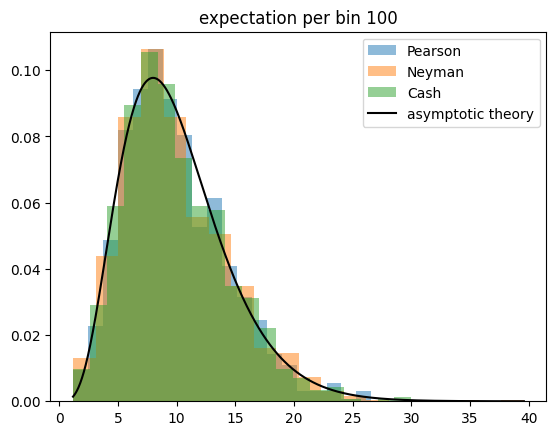

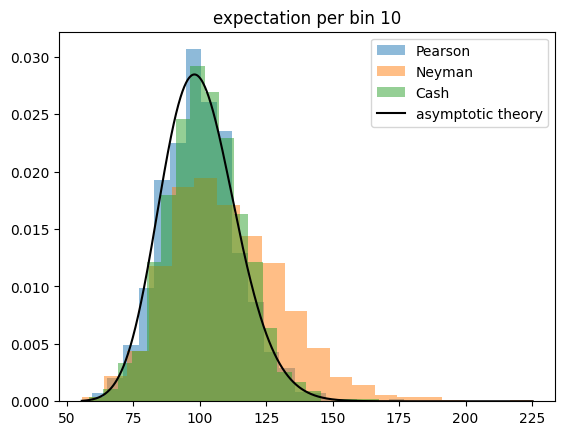

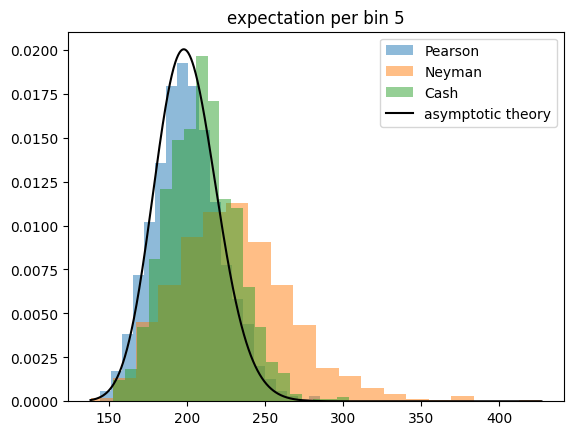

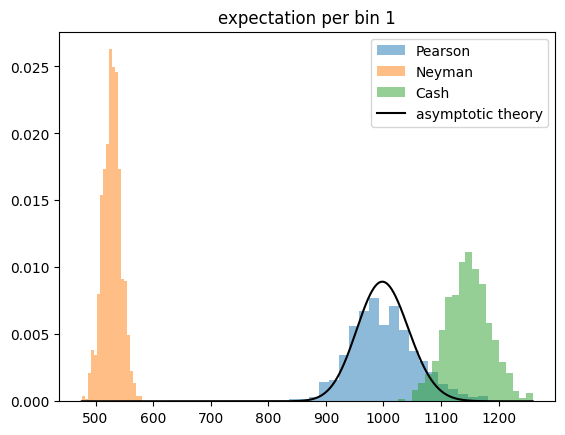

In [6]:
for bins in (10, 100, 200, 1000):
    yc = []
    yp = []
    yn = []
    mu = 1000 / bins
    for seed in range(1000):
        rng = np.random.default_rng(seed)
        n = rng.poisson(mu, size=bins)
        yc.append(cost.poisson_chi2(n, mu))
        yp.append(cost.chi2(n, mu ** 0.5, mu))
        yn.append(cost.chi2(n, (n + 1) ** 0.5, mu))
    plt.figure()
    for i, (label, y) in enumerate((("Pearson", yp), ("Neyman", yn), ("Cash", yc))):
        plt.hist(
            y,
            density=True,
            bins=20,
            color=f"C{i}",
            alpha=0.5,
            label=label,
        )
    n_all = np.concatenate([yp, yc, yn])
    xm = np.linspace(np.min(n_all), np.max(n_all), 1000)
    plt.plot(xm, chi2(bins).pdf(xm), color="k", label="asymptotic theory")
    plt.title(f"expectation per bin {mu:.0f}")
    plt.legend()

The Cash statistic is better than Neyman's test statistic, also because it does not require an ad hoc solution to handle categories with zero observations, but only
Pearson's test statistic follows a chi-square distribution even if the expectation per bin becomes very small.

This result is unintuitive, because Pearson's and Neyman's test statistics are derived under the assumption that the observations are normally distributed around the expectations, which is not the case for Poisson distributed observations and small expectations. The Cash statistic is derived from a likelihood ratio with a likelihood based on the correct Poisson distribution, so one assumes it to perform better than the others.

Furthermore, when these test statistics are used for point estimation (they can be minimized to yield point estimates for model parameters), [the Cash statistic is the only which is unbiased even for small expectations](https://inspirehep.net/literature/1683309). This effect is not visible here, because in this toy experiment we do not estimate parameters from the sample.

So we run the toy experiment once more, but this time we estimate the constant density per bin by minimizing the respective test statistic. We also investigate the golden combination, Pearson's test statistic computed with an estimate for the expectation obtained by minimizing the Cash statistic.

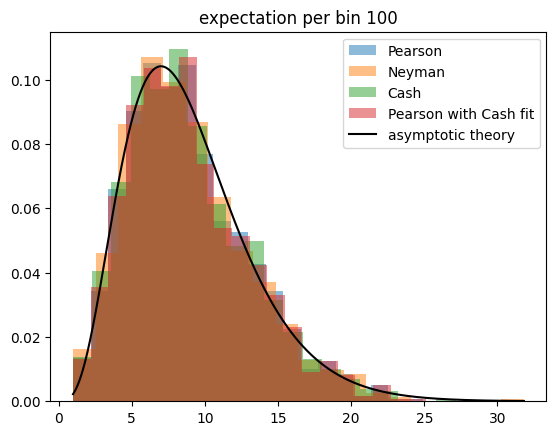

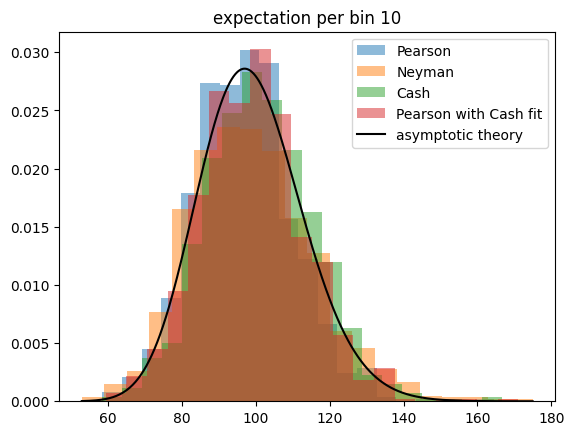

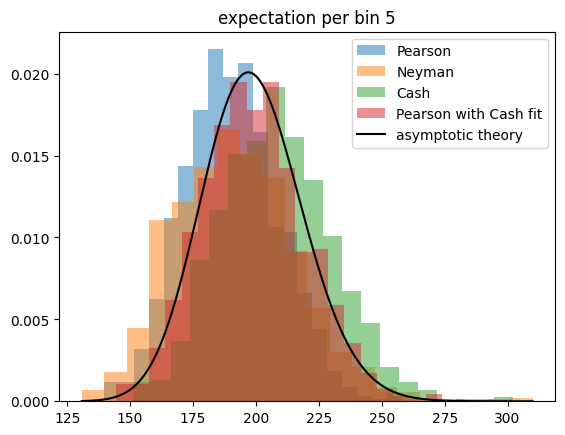

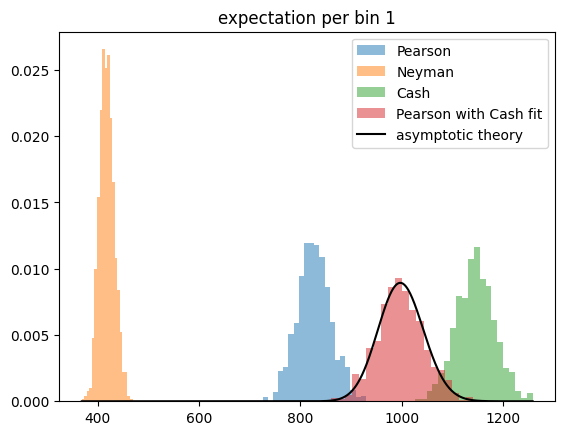

In [10]:
for bins in (10, 100, 200, 1000):
    yc = []
    yc2 = []
    yp = []
    yn = []
    mu = 1000 / bins
    for seed in range(1000):
        rng = np.random.default_rng(seed)
        n = rng.poisson(mu, size=bins)

        m = Minuit(lambda mu: cost.poisson_chi2(n, mu), mu=mu)
        m.migrad()
        assert m.valid
        yc.append(m.fval)
        muest = m.values[0]
        yc2.append(cost.chi2(n, muest ** 0.5, muest))

        m = Minuit(lambda mu: cost.chi2(n, mu ** 0.5, mu), mu=mu)
        m.migrad()
        assert m.valid
        yp.append(m.fval)

        m = Minuit(lambda mu: cost.chi2(n, (n+1) ** 0.5, mu), mu=mu)
        m.migrad()
        assert m.valid
        yn.append(m.fval)

    plt.figure()
    for i, (label, y) in enumerate((("Pearson", yp), ("Neyman", yn), ("Cash", yc), ("Pearson with Cash fit", yc2))):
        plt.hist(
            y,
            density=True,
            bins=20,
            color=f"C{i}",
            alpha=0.5,
            label=label,
        )
    n_all = np.concatenate([yp, yc, yn])
    xm = np.linspace(np.min(n_all), np.max(n_all), 1000)
    # we must subtract one, since we have estimated one parameter from the sample
    plt.plot(xm, chi2(bins-1).pdf(xm), color="k", label="asymptotic theory")
    plt.title(f"expectation per bin {mu:.0f}")
    plt.legend()

We find that Pearson's test statistic has a perfect chi-square distribution, if the expectation is estimated by minimizing the Cash statistic.